## Diabetes Classifier
#### by: Joseph Curtis

# Install Libraries
First, we will need to import other libraries used.
*NOTE: this step is necessary to execute **before** all other steps below.*

In [11]:
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn import linear_model, metrics, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold, cross_val_score

# Data Preparation and Initial Analysis
Here we focus on preparing and analyzing health indicator data for diabetes from the years 2015 and 2021. The goal is to combine these datasets to form a comprehensive view of the data, which can later be used for machine learning modeling. The following steps are taken:
1. Import Libraries
2. Load the Data
3. Combine the DataFrames

In [12]:
# file names and urls
filepath_2015 = "data/BRFSS2015.csv"
filepath_2021 = "data/BRFSS2021.csv"
df1 = pd.read_csv(filepath_2015)
df2 = pd.read_csv(filepath_2021)

# Combine the two DataFrames
combined_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

# Display the first few rows of the combined dataframe and its shape to verify 
# the combination
combined_df_info = combined_df.head(), combined_df.shape

combined_df_info

(   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
 0              0.0     1.0       0.0        1.0  26.0     0.0     0.0   
 1              0.0     1.0       1.0        1.0  26.0     1.0     1.0   
 2              0.0     0.0       0.0        1.0  26.0     0.0     0.0   
 3              0.0     1.0       1.0        1.0  28.0     1.0     0.0   
 4              0.0     0.0       0.0        1.0  29.0     1.0     0.0   
 
    HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
 0                   0.0           1.0     0.0  ...            1.0   
 1                   0.0           0.0     1.0  ...            1.0   
 2                   0.0           1.0     1.0  ...            1.0   
 3                   0.0           1.0     1.0  ...            1.0   
 4                   0.0           1.0     1.0  ...            1.0   
 
    NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
 0          0.0      3.0       5.0      30.0       0

# Removing Features
Here we remove features deemed irrelevant for modeling purposes. We specify a list of columns to be removed and then drop these columns from the combined DataFrame

In [13]:
# Remove irrelevant features from the combined dataset
columns_to_remove = ['CholCheck', 'AnyHealthcare', 'NoDocbcCost', 'Education', 'Income']
reduced_df = combined_df.drop(columns=columns_to_remove)

# Display the first few rows of the reduced dataframe to verify the removal
reduced_df.head()

,Diabetes_binary,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,0.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0
1,0.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0
2,0.0,0.0,0.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0
3,0.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0
4,0.0,0.0,0.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0


# Check for Missing Values
Here we check for missing values in the combined dataset. Note there are *NO* missing values found.

In [3]:
# Check for missing values in the reduced dataset
missing_values = reduced_df.isnull().sum()

missing_values ## no missing values found

Diabetes_binary         0
HighBP                  0
HighChol                0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
dtype: int64

# Data Type Optimization Analysis
Here we perform a preliminary analysis aimed at optimizing data storage and processing efficiency by examining the range of values for selected features within the reduced dataset. We also calculate the memory used before we adjust the data types-- this is our baseline for memory usage.

In [4]:
# Check the range of values for the specified features to determine suitable data types
features_to_optimize = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']
data_types_optimization = reduced_df[features_to_optimize].describe().loc[['min', 'max']]

# Memory used before reducing data types
memory_before = reduced_df.memory_usage(index=True).sum()

data_types_optimization

,BMI,GenHlth,MentHlth,PhysHlth,Age
min,12.0,1.0,0.0,0.0,1.0
max,99.0,5.0,30.0,30.0,13.0


# Data Type Conversion for Efficiency
We enhance the dataset's memory efficiency by converting specified binary columns to boolean data types. We print the memory usage before and after the operation to demonstrate the effectiveness of this optimization in reducing the dataset's memory consumption.

In [5]:
binary_columns = ['Diabetes_binary', 'HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'DiffWalk', 'Sex']
for column in binary_columns:
    reduced_df[column] = reduced_df[column].astype('bool')

# After data types reduces memory size
memory_after = reduced_df.memory_usage(index=True).sum()

print("Dataframe memory used before:", memory_before)
print("Dataframe memory used after:  ", memory_after)

Dataframe memory used before: 18744740
Dataframe memory used after:   7167188


# Logistic Regression Model for Diabetes Prediction
Here we prepare data for machine learning, specifically using a logistic regression model to predict diabetes. First, numerical columns are identified and scaled using MinMaxScaler to ensure all features contribute equally to the model without bias from varying scales. A logistic regression model is then initialized with specific parameters. The dataset is split into features (X_log) and the target variable (y_log). The data is further divided into training and test sets to evaluate the model's performance on unseen data.

After training the logistic regression model, predictions are made on the test set. The model's effectiveness is assessed using accuracy, confusion matrix, and classification report, providing a comprehensive overview of its predictive capabilities in distinguishing between diabetic and non-diabetic individuals.

In [6]:
###### Logistic Regression algorithm ######

# Selecting numerical columns (excluding binary/boolean columns)
numerical_columns = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical features
reduced_df[numerical_columns] = scaler.fit_transform(reduced_df[numerical_columns])

mylog_model = linear_model.LogisticRegression(solver='saga', max_iter=1000)

# 'X' is the feature set and 'y' is the target variable
X_log = reduced_df.drop('Diabetes_binary', axis=1)
y_log = reduced_df['Diabetes_binary'].astype('bool')  # Ensuring the target is boolean

# Splitting the dataset into the Training set and Test set
X_log_train, X_log_test, y_log_train, y_log_test = model_selection.train_test_split(X_log, y_log, test_size=0.25, random_state=42)

mylog_model.fit(X_log_train, y_log_train)

y_pred_log = mylog_model.predict(X_log_test)

# Evaluate the model
accuracy = accuracy_score(y_log_test, y_pred_log)
conf_matrix = confusion_matrix(y_log_test, y_pred_log)
class_report = classification_report(y_log_test, y_pred_log)

print("\nLogistic Regression prediction results:")
print(f"Accuracy: {round(accuracy*100,2)} %")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Logistic Regression prediction results:
Accuracy: 74.59 %
Confusion Matrix:
[[12557  4656]
 [ 4101 13143]]
Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.73      0.74     17213
        True       0.74      0.76      0.75     17244

    accuracy                           0.75     34457
   macro avg       0.75      0.75      0.75     34457
weighted avg       0.75      0.75      0.75     34457



# Cross-Validation of Logistic Regression Model
Next we perform a cross-validation process on the logistic regression model to verify its reliability across different subsets of the dataset. By utilizing the KFold method with 5 splits and shuffling enabled, the dataset is divided into distinct subsets to conduct multiple training and testing cycles. The average of these scores is calculated and displayed, offering a robust measure of the model's overall performance. This approach helps to ensure that the model's predictive accuracy is not overly dependent on any particular partition of the data, thereby increasing confidence in its generalizability.

In [7]:
# Verify model by averaging different test/train splits
k_folds = KFold(n_splits = 5, shuffle=True)
# The number of folds determines the test/train split for each iteration. 
# So 5 folds has 5 different mutually exclusive training sets. 
# That's a 1 to 4 (or .20 to .80) testing/training split for each of the 5 iterations.

log_scores = cross_val_score(mylog_model, X_log, y_log)
# This shows the average score. Print 'scores' to see an array of individual iteration scores.
print("Logistic Regression Average Prediction Score: ", round(log_scores.mean()*100, 2), "%")

Logistic Regression Average Prediction Score:  74.25 %


# Confusion Matrix Visual
Confusion matrixes are used to evaluate the performance in classifying diabetic and non-diabetic individuals.

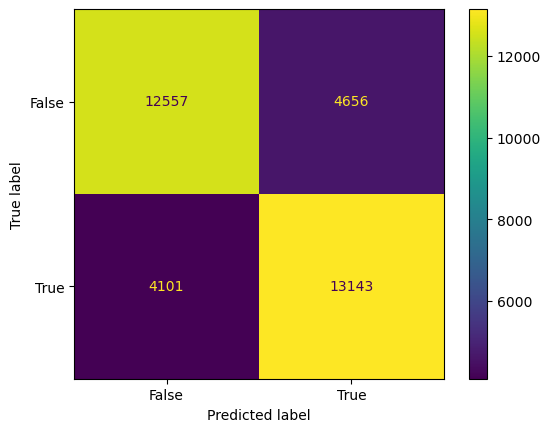

In [8]:
# Plot confusion matrix
graph_confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_log_test, y_pred_log)

# Histogram Visual
Here we generate histograms for all numerical data, providing a visual distribution analysis of each (non-binary) feature.

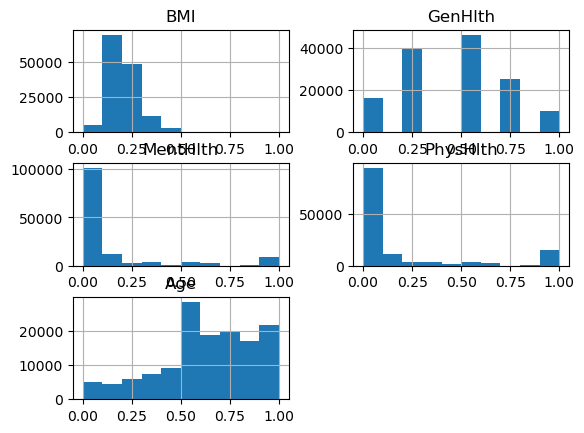

In [9]:
# Plot histogram
graph_histogram = reduced_df.hist()